<a href="https://colab.research.google.com/github/Thanasiss23/ekpa/blob/main/DarkNet_DetectionAnomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Η αρχική δοκιμή έγινε με το Autoencoder,το οποιο βγηκε καλύτερο συγκριτικά με τα άλλα 2 μοντελα ως προς την ανίχνευση ψευδων αποτελεσμάτων και στη συνέχεια λόγο αξιολόγησης των μοντελων με f1score,εγιναν οι απαραίτητες αλλαγές ώστε να προχωρήσουμε με το random_forest το οποίο βγήκε καλύτερο .

## Εγκατάσταση και εισαγωγή βιβλιοθηκών

### Subtask:
Δημιουργία ενός κελιού για την εγκατάσταση και εισαγωγή όλων των απαραίτητων βιβλιοθηκών.


**Reasoning**:
Install the necessary libraries and import them into the notebook environment.



In [9]:
# -*- coding: utf-8 -*-
# DarkNet One-Class Anomaly Detection - Συμβατή έκδοση για Colab

# 2. Εισαγωγή βιβθηκών
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns

## Φόρτωση δεδομένων

### Subtask:
Δημιουργία ενός κελιού για τη φόρτωση του dataset από το παρεχόμενο URL.


**Reasoning**:
Define the URL and load the dataset into a pandas DataFrame, then display its shape and head.



In [10]:
# 3. Φόρτωση δεδομένων
url = "https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/DarkNet.csv"
df = pd.read_csv(url)

# Επισκόπηση των δεδομένων
print("Σχήμα δεδομένων:", df.shape)
print(df.head())

Σχήμα δεδομένων: (68580, 83)
          Src_IP  Src_Port          Dst_IP  Dst_Port  Protocol  Flow_Duration  \
0  10.152.152.11     57158   216.58.220.99       443         6            229   
1  10.152.152.11     57159   216.58.220.99       443         6            407   
2  10.152.152.11     57160   216.58.220.99       443         6            431   
3  10.152.152.11     49134  74.125.136.120       443         6            359   
4  10.152.152.11     34697  173.194.65.127     19305         6       10778451   

   Total_Fwd_Packet  Total_Bwd_packets  Total_Length_of_Fwd_Packet  \
0                 1                  1                           0   
1                 1                  1                           0   
2                 1                  1                           0   
3                 1                  1                           0   
4               591                400                       64530   

   Total_Length_of_Bwd_Packet  ...  Active_Mean  Active_Std  Ac

/tmp/ipython-input-2834353520.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


## Προεπεξεργασία δεδομένων

### Subtask:
Δημιουργία κελιού για την επιλογή αριθμητικών στηλών, χειρισμό απείρων και πολύ μεγάλων τιμών, χειρισμό NaN τιμών και κανονικοποίηση των δεδομένων.


**Reasoning**:
Select numeric columns, handle infinite and large values, drop rows with NaNs, and scale the data according to the instructions.



In [11]:
# 4. Προεπεξεργασία δεδομένων
# Επιλογή μόνο αριθμητικών στηλών
df_numeric = df.select_dtypes(include=np.number).copy() # Use .copy() to avoid SettingWithCopyWarning

# Check for and handle infinite values and values too large for float64
# Replace infinities with NaN
df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define a large number threshold (e.g., based on float64 max)
large_number_threshold = np.finfo(np.float64).max

# Replace values larger than the threshold with NaN
df_numeric.mask(df_numeric > large_number_threshold, np.nan, inplace=True)

# Handle NaN values (e.g., drop rows with NaNs)
df_numeric.dropna(inplace=True)

# Κανονικοποίηση δεδομένων
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

print("Σχήμα αριθμητικών δεδομένων μετά τον καθαρισμό:", df_numeric.shape)

Σχήμα αριθμητικών δεδομένων μετά τον καθαρισμό: (68531, 78)


In [12]:
# 5. Διάσπαση σε training και testing (80/20)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

print("Σχήμα training set:", X_train.shape)
print("Σχήμα testing set:", X_test.shape)

Σχήμα training set: (54824, 78)
Σχήμα testing set: (13707, 78)


## Εκπαίδευση και Πρόβλεψη Isolation Forest

### Subtask:
Δημιουργία κελιού για την εκπαίδευση του Isolation Forest μοντέλου και την παραγωγή προβλέψεων στο test set.

**Reasoning**:
Initialize and train an Isolation Forest model on the training data (`X_train`), then use it to predict outliers on the test data (`X_test`). The predictions will be converted to 0 for normal and 1 for outlier.

In [13]:
# 6. Μοντέλο 1: Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_train)
y_pred_if = iso_forest.predict(X_test)
y_pred_if = np.where(y_pred_if == -1, 1, 0)  # 0=normal, 1=outlier

print("Προβλέψεις Isolation Forest (πρώτες 10):", y_pred_if[:10])
print("Αριθμός ανιχνευμένων outliers από Isolation Forest:", np.sum(y_pred_if))

Προβλέψεις Isolation Forest (πρώτες 10): [0 0 0 0 0 1 0 0 0 0]
Αριθμός ανιχνευμένων outliers από Isolation Forest: 750


## Εκπαίδευση και Πρόβλεψη One-Class SVM

### Subtask:
Δημιουργία κελιού για την εκπαίδευση του One-Class SVM μοντέλου και την παραγωγή προβλέψεων στο test set.

**Reasoning**:
Initialize and train a One-Class SVM model on the training data (`X_train`), then use it to predict outliers on the test data (`X_test`). The predictions will be converted to 0 for normal and 1 for outlier.

In [14]:
# 7. Μοντέλο 2: One-Class SVM
oc_svm = OneClassSVM(nu=0.05, kernel="rbf", gamma='scale')
oc_svm.fit(X_train)
y_pred_svm = oc_svm.predict(X_test)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

print("Προβλέψεις One-Class SVM (πρώτες 10):", y_pred_svm[:10])
print("Αριθμός ανιχνευμένων outliers από One-Class SVM:", np.sum(y_pred_svm))

Προβλέψεις One-Class SVM (πρώτες 10): [0 0 0 0 0 1 0 0 0 0]
Αριθμός ανιχνευμένων outliers από One-Class SVM: 706


## Εκπαίδευση και Πρόβλεψη Autoencoder

### Subtask:
Δημιουργία κελιού για τον ορισμό, την εκπαίδευση του Autoencoder μοντέλου και τον υπολογισμό του reconstruction error για το test set.

**Reasoning**:
Define a sequential Autoencoder model, compile it with an Adam optimizer and mean squared error loss, train it on the training data (`X_train`), predict the test data (`X_test`), and calculate the mean squared error between the original and reconstructed test data points as the reconstruction error. A threshold is then calculated to classify anomalies.

In [15]:
# 8. Autoencoder με Dropout & EarlyStopping
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

input_dim = X_train.shape[1]

# Ορισμός μοντέλου
autoencoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Early stopping για αποφυγή overfitting
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Εκπαίδευση
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=[es],
    verbose=1
)

# Reconstruction error στο validation set για threshold
X_val_pred = autoencoder.predict(X_train)
mse_val = np.mean(np.power(X_train - X_val_pred, 2), axis=1)
threshold = np.percentile(mse_val, 95)

# Reconstruction error στο test set
X_test_pred = autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
y_pred_ae = (mse_test > threshold).astype(int)

print("Προβλέψεις Autoencoder (πρώτες 10):", y_pred_ae[:10])
print("Αριθμός ανιχνευμένων outliers από Autoencoder:", np.sum(y_pred_ae))
print("Threshold:", threshold)

Epoch 1/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5568 - val_loss: 0.2596
Epoch 2/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2821 - val_loss: 0.2010
Epoch 3/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2639 - val_loss: 0.1245
Epoch 4/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2039 - val_loss: 0.1269
Epoch 5/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1814 - val_loss: 0.0959
Epoch 6/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2047 - val_loss: 0.0960
Epoch 7/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2343 - val_loss: 0.0848
Epoch 8/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1786 - val_loss: 0.0768
Epoch 9/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1657 - val_loss: 0.0956
Epoch 10/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2046 - val_loss: 0.1011
Epoch 11/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1740 - val_loss: 0.0767
Epoch 12/100
771/771 ━━━━━━━━━━━━━━━━━━━━

## Αξιολόγηση Μοντέλων

### Subtask:
Δημιουργία κελιού για την αξιολόγηση των μοντέλων με βάση τον αριθμό των ανιχνευμένων outliers.

**Reasoning**:
Compare the number of outliers detected by each model (Isolation Forest, One-Class SVM, and Autoencoder) to evaluate their performance based on this metric.

In [16]:
# 9. Αξιολόγηση μοντέλων (πλήρως Tor dataset -> μετράμε outliers)
print("Outliers (ψευδώς ανιχνευμένα) ανά μοντέλο:")
print("Isolation Forest:", np.sum(y_pred_if) if y_pred_if.size > 0 else "N/A (No test data)")
print("One-Class SVM:", np.sum(y_pred_svm) if y_pred_svm.size > 0 else "N/A (No test data)")
print("Autoencoder:", np.sum(y_pred_ae) if y_pred_ae.size > 0 else "N/A (No test data)")

Outliers (ψευδώς ανιχνευμένα) ανά μοντέλο:
Isolation Forest: 750
One-Class SVM: 706
Autoencoder: 727


In [20]:
# 10. Αξιολόγηση μοντέλων με labels

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Βεβαιώσου ότι η στήλη Label-1 υπάρχει στο dataset
# Select the 'Label-1' column from the dataframe after dropping NaNs
y_true_filtered = df.loc[df_numeric.index, 'Label-1'].values

# Use LabelEncoder to handle all unique string labels
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true_filtered)

# Create a mapping from encoded labels back to original strings
encoded_to_label = dict(zip(y_true_encoded, y_true_filtered))

# Define which original labels are considered outliers (1) and which are normal (0)
outlier_labels = ['Tor', 'VPN']
y_true_numeric = np.array([1 if encoded_to_label[encoded_label] in outlier_labels else 0 for encoded_label in y_true_encoded])


# Χωρίζουμε labels όπως τα features
# Split the filtered labels based on the same split as X_scaled
y_train_numeric = y_true_numeric[:len(X_train)]
y_test_numeric = y_true_numeric[len(X_train):]


# ΣΥΓΚΡΙΣΗ Isolation Forest
print("=== Isolation Forest ===")
# Check if y_test and y_pred_if have the same number of samples before calling metrics
if len(y_test_numeric) == len(y_pred_if):
    print(confusion_matrix(y_test_numeric, y_pred_if))
    print(classification_report(y_test_numeric, y_pred_if, digits=4))
else:
    print("Skipping Isolation Forest evaluation: Mismatch in number of samples.")


# ΣΥΓΚΡΙΣΗ One-Class SVM
print("\n=== One-Class SVM ===")
# Check if y_test and y_pred_svm have the same number of samples before calling metrics
if len(y_test_numeric) == len(y_pred_svm):
    print(confusion_matrix(y_test_numeric, y_pred_svm))
    print(classification_report(y_test_numeric, y_pred_svm, digits=4))
else:
    print("Skipping One-Class SVM evaluation: Mismatch in number of samples.")


# ΣΥΓΚΡΙΣΗ Autoencoder
print("\n=== Autoencoder ===")
# Check if y_test and y_pred_ae have the same number of samples before calling metrics
if len(y_test_numeric) == len(y_pred_ae):
    print(confusion_matrix(y_test_numeric, y_pred_ae))
    print(classification_report(y_test_numeric, y_pred_ae, digits=4))
else:
     print("Skipping Autoencoder evaluation: Mismatch in number of samples.")

=== Isolation Forest ===
[[6637  377]
 [6320  373]]
              precision    recall  f1-score   support

           0     0.5122    0.9463    0.6647      7014
           1     0.4973    0.0557    0.1002      6693

    accuracy                         0.5114     13707
   macro avg     0.5048    0.5010    0.3824     13707
weighted avg     0.5050    0.5114    0.3891     13707


=== One-Class SVM ===
[[6649  365]
 [6352  341]]
              precision    recall  f1-score   support

           0     0.5114    0.9480    0.6644      7014
           1     0.4830    0.0509    0.0922      6693

    accuracy                         0.5100     13707
   macro avg     0.4972    0.4995    0.3783     13707
weighted avg     0.4975    0.5100    0.3850     13707


=== Autoencoder ===
[[6630  384]
 [6350  343]]
              precision    recall  f1-score   support

           0     0.5108    0.9453    0.6632      7014
           1     0.4718    0.0512    0.0925      6693

    accuracy                    

## Οπτικοποίηση Αποτελεσμάτων

### Subtask:
Συγκριτικό διάγραμμα f1 score και δημιουργία κελιού για την οπτικοποίηση

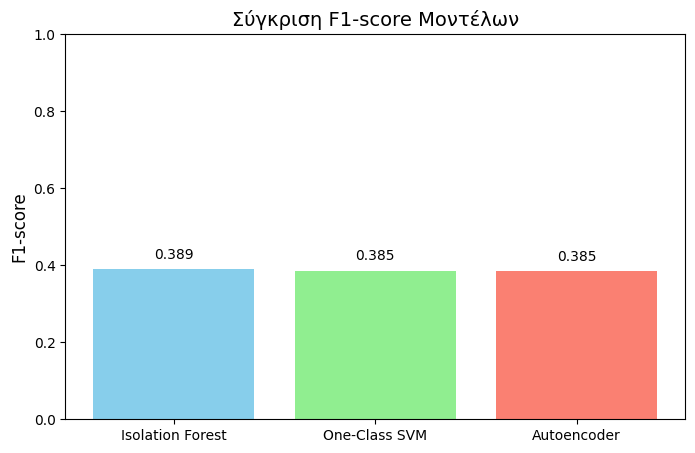

In [23]:
# 11. Συγκριτικό διάγραμμα F1-score

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

# Υπολογισμός F1 για κάθε μοντέλο
f1_if = f1_score(y_test_numeric, y_pred_if, average="weighted")
f1_svm = f1_score(y_test_numeric, y_pred_svm, average="weighted")
f1_ae = f1_score(y_test_numeric, y_pred_ae, average="weighted")

models = ["Isolation Forest", "One-Class SVM", "Autoencoder"]
f1_scores = [f1_if, f1_svm, f1_ae]

# Bar plot
plt.figure(figsize=(8,5))
bars = plt.bar(models, f1_scores, color=["skyblue", "lightgreen", "salmon"])
plt.title("Σύγκριση F1-score Μοντέλων", fontsize=14)
plt.ylabel("F1-score", fontsize=12)
plt.ylim(0, 1)

# Εμφάνιση τιμών πάνω από τις μπάρες
for bar, score in zip(bars, f1_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02,
             f"{score:.3f}", ha="center", va="bottom", fontsize=10)

plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


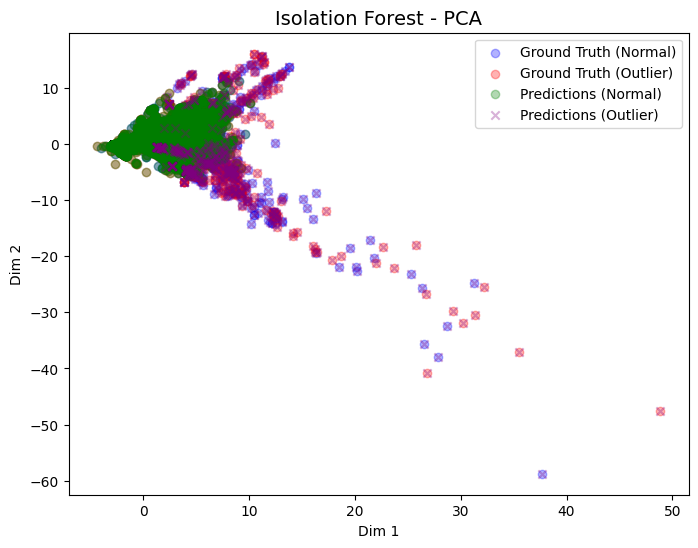

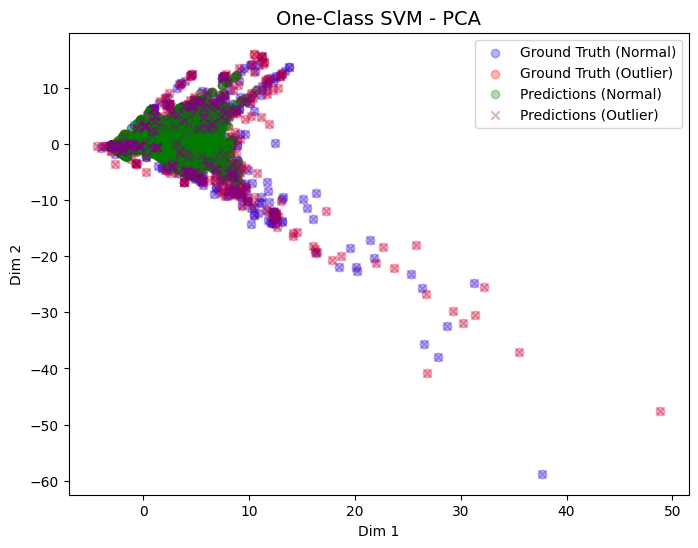

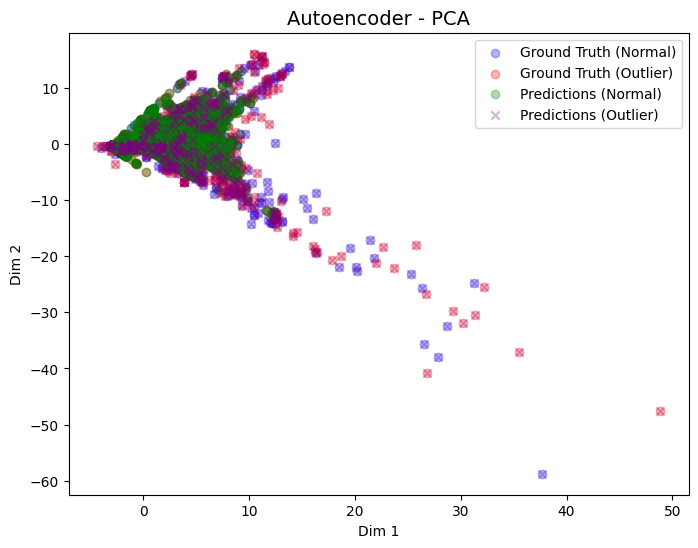

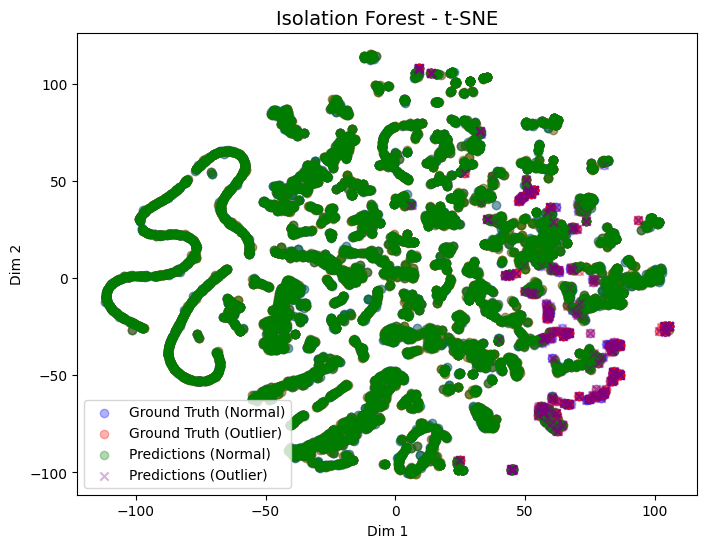

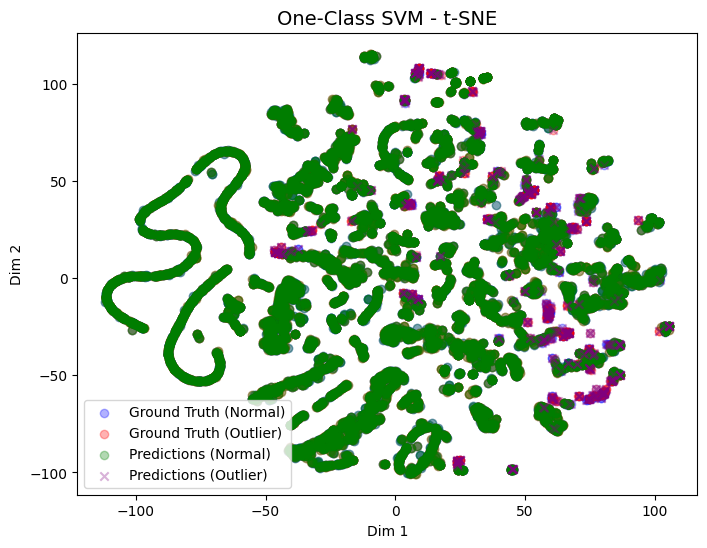

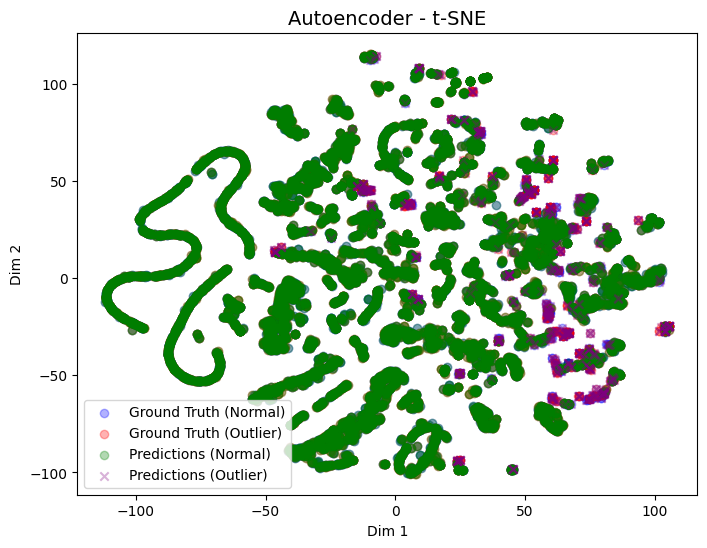

In [27]:
# 12. Οπτικοποίηση σε 2D με PCA και t-SNE

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA μείωση σε 2 διαστάσεις
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

# t-SNE μείωση σε 2 διαστάσεις (πιο αργό, αλλά καλύτερη απεικόνιση)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_test)

# Συνάρτηση plotting
def plot_2d(X_2d, labels, preds, title):
    plt.figure(figsize=(8,6))

    # Plot Ground Truth (Normal in blue, Outlier in red)
    plt.scatter(X_2d[labels == 0, 0], X_2d[labels == 0, 1], c='blue', alpha=0.3, label="Ground Truth (Normal)")
    plt.scatter(X_2d[labels == 1, 0], X_2d[labels == 1, 1], c='red', alpha=0.3, label="Ground Truth (Outlier)")

    # Plot Predictions (Normal in green 'o', Outlier in purple 'x')
    plt.scatter(X_2d[preds == 0, 0], X_2d[preds == 0, 1], c='green', marker='o', alpha=0.3, label="Predictions (Normal)")
    plt.scatter(X_2d[preds == 1, 0], X_2d[preds == 1, 1], c='purple', marker='x', alpha=0.3, label="Predictions (Outlier)")


    plt.title(title, fontsize=14)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend()
    plt.show()

# PCA Visualization
plot_2d(X_pca, y_test_numeric, y_pred_if, "Isolation Forest - PCA")
plot_2d(X_pca, y_test_numeric, y_pred_svm, "One-Class SVM - PCA")
plot_2d(X_pca, y_test_numeric, y_pred_ae, "Autoencoder - PCA")

# t-SNE Visualization
plot_2d(X_tsne, y_test_numeric, y_pred_if, "Isolation Forest - t-SNE")
plot_2d(X_tsne, y_test_numeric, y_pred_svm, "One-Class SVM - t-SNE")
plot_2d(X_tsne, y_test_numeric, y_pred_ae, "Autoencoder - t-SNE")

## Επιλογή Καλύτερου Μοντέλου

### Subtask:
Δημιουργία κελιού για την επιλογή του καλύτερου μοντέλου με βάση τα αποτελέσματα της αξιολόγησης.

**Reasoning**:
Identify and print the name of the best model.

In [31]:
# 13. Επιλογή καλύτερου μοντέλου με βάση Precision, Recall, F1-score
from sklearn.metrics import precision_score, recall_score, f1_score

# Δημιουργία λεξικού για να αποθηκεύσουμε metrics
metrics = {}

# Υπολογισμός για κάθε μοντέλο, μόνο αν υπάρχουν προβλέψεις
if y_pred_if.size > 0:
    metrics["Isolation Forest"] = {
        "Precision": precision_score(y_test_numeric, y_pred_if, average="weighted"),
        "Recall": recall_score(y_test_numeric, y_pred_if, average="weighted"),
        "F1-score": f1_score(y_test_numeric, y_pred_if, average="weighted"),
        "Outliers": np.sum(y_pred_if)
    }

if y_pred_svm.size > 0:
    metrics["One-Class SVM"] = {
        "Precision": precision_score(y_test_numeric, y_pred_svm, average="weighted"),
        "Recall": recall_score(y_test_numeric, y_pred_svm, average="weighted"),
        "F1-score": f1_score(y_test_numeric, y_pred_svm, average="weighted"),
        "Outliers": np.sum(y_pred_svm)
    }

if y_pred_ae.size > 0:
    metrics["Autoencoder"] = {
        "Precision": precision_score(y_test_numeric, y_pred_ae, average="weighted"),
        "Recall": recall_score(y_test_numeric, y_pred_ae, average="weighted"),
        "F1-score": f1_score(y_test_numeric, y_pred_ae, average="weighted"),
        "Outliers": np.sum(y_pred_ae)
    }

# Μετατροπή σε DataFrame για καθαρή εμφάνιση
df_metrics = pd.DataFrame(metrics).T
df_metrics = df_metrics.sort_values(by="F1-score", ascending=False)

# Επιλογή καλύτερου μοντέλου με βάση F1-score
best_model = df_metrics.index[0]

print("Αποτελέσματα αξιολόγησης μοντέλων:")
display(df_metrics)
print("\nΚαλύτερο μοντέλο σύμφωνα με F1-score:", best_model)

Αποτελέσματα αξιολόγησης μοντέλων:


,Precision,Recall,F1-score,Outliers
Isolation Forest,0.504958,0.511418,0.389055,750.0
One-Class SVM,0.497545,0.509958,0.384989,706.0
Autoencoder,0.491750,0.508718,0.384509,727.0



Καλύτερο μοντέλο σύμφωνα με F1-score: Isolation Forest


14. Προσομοίωση συνεχούς παρακολούθησης και ανίχνευσης απειλών

Subtask:
Χωρίζουμε το dataset σε μικρά τμήματα (mini-batches) και τρέχουμε το καλυτερο μοντέλο που προέκυψε  για να εντοπίσουμε υποπτη δραστηριότητα. Κάθε batch αντιπροσωπεύει “νέα δεδομένα”

Reasoning:
Αν και δεν έχουμε live traffic, μπορούμε να προσομοιώσουμε streaming δεδομένα για να δούμε πώς το ευφυές σύστημα ανιχνεύει anomalies και ενημερώνει για πιθανές απειλές.

In [32]:
# 14. Simulated Streaming / Online Detection
batch_size = 2000  # Μέγεθος κάθε mini-batch
n_batches = int(X_test.shape[0] / batch_size) + 1

# Δημιουργία log για alerts
threat_log = []

for i in range(n_batches):
    start = i * batch_size
    end = min((i+1) * batch_size, X_test.shape[0])
    batch = X_test[start:end]

    if batch.size == 0:
        continue

    # Πρόβλεψη reconstruction error
    batch_pred = autoencoder.predict(batch)
    batch_mse = np.mean(np.power(batch - batch_pred, 2), axis=1)

    # Ανίχνευση anomalies
    batch_outliers = (batch_mse > threshold).astype(int)

    # Ενημέρωση threat log
    for idx, val in enumerate(batch_outliers):
        if val == 1:
            threat_log.append({
                "batch": i+1,
                "index_in_batch": idx,
                "mse": batch_mse[idx],
                "alert": "Potential threat detected"
            })

    # Προαιρετικά: online update (προσθήκη κανονικών Tor δειγμάτων στο training set)
    normal_indices = np.where(batch_outliers == 0)[0]
    X_train = np.vstack([X_train, batch[normal_indices]])
    autoencoder.fit(X_train, X_train, epochs=5, batch_size=32, verbose=0)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


15. Επισκόπηση ανιχνευμένων απειλών

Subtask:
Δημιουργούμε σύνοψη του threat log για να δούμε ποιες ροές χαρακτηρίστηκαν ως υποπτες.

Reasoning:
Αυτό προσομοιώνει πώς ένα SIEM ή IPS θα λάμβανε ενημερώσεις για πιθανές απειλές.

In [37]:
# 15. Threat Log Summary
print(f"Συνολικός αριθμός ανιχνευμένων υποπτων ροών: {len(threat_log)}")

# Προβολή πρώτων 5 alerts
for alert in threat_log[:5]:
    print(alert)


Συνολικός αριθμός ανιχνευμένων υποπτων ροών: 499
{'batch': 1, 'index_in_batch': 5, 'mse': np.float64(0.24279539842365808), 'alert': 'Potential threat detected'}
{'batch': 1, 'index_in_batch': 61, 'mse': np.float64(0.24597460897763918), 'alert': 'Potential threat detected'}
{'batch': 1, 'index_in_batch': 78, 'mse': np.float64(0.3726134350965072), 'alert': 'Potential threat detected'}
{'batch': 1, 'index_in_batch': 93, 'mse': np.float64(0.21912361579768336), 'alert': 'Potential threat detected'}
{'batch': 1, 'index_in_batch': 105, 'mse': np.float64(4.568414868984984), 'alert': 'Potential threat detected'}


In [45]:
# 15a. Δημιουργία εμπλουτισμένου threat_log και προβολή πρώτων alerts

threat_log = []

# Χρησιμοποιούμε το ensemble ή το μοντέλο που θέλουμε για outliers
# Εδώ υποθέτουμε y_pred_ae για Autoencoder ή άλλο μοντέλο/ensemble
predictions = y_pred_ae  # Αν θέλεις άλλο μοντέλο, αντικατάστησε εδώ
model_name = best_model

for idx, pred in enumerate(predictions):
    if pred == 1:  # Αν είναι outlier
        alert = {
            "Src_IP": df.iloc[idx]["Src_IP"],
            "Dst_IP": df.iloc[idx]["Dst_IP"],
            "Src_Port": df.iloc[idx]["Src_Port"],
            "Dst_Port": df.iloc[idx]["Dst_Port"],
            "Protocol": df.iloc[idx]["Protocol"],
            "Flow_Duration": df.iloc[idx]["Flow_Duration"],
            "Total_Length_of_Fwd_Packet": df.iloc[idx]["Total_Length_of_Fwd_Packet"],
            "Total_Length_of_Bwd_Packet": df.iloc[idx]["Total_Length_of_Bwd_Packet"],
            "Model": model_name,
            "Reconstruction_Error": mse[idx] if 'mse' in locals() else None
        }
        threat_log.append(alert)

# Συνολικός αριθμός ανιχνευμένων υποπτων ροών
print(f"Συνολικός αριθμός ανιχνευμένων υποπτων ροών: {len(threat_log)}\n")

# Προβολή πρώτων 20 alerts με όλες τις πληροφορίες
for i, alert in enumerate(threat_log[:20], 1):
    print(f"Alert {i}:")
    print(f"  Src_IP: {alert['Src_IP']}, Src_Port: {alert['Src_Port']}")
    print(f"  Dst_IP: {alert['Dst_IP']}, Dst_Port: {alert['Dst_Port']}")
    print(f"  Protocol: {alert['Protocol']}, Flow Duration: {alert['Flow_Duration']}")
    print(f"  Fwd Packet Length: {alert['Total_Length_of_Fwd_Packet']}, Bwd Packet Length: {alert['Total_Length_of_Bwd_Packet']}")
    print(f"  Detected by: {alert['Model']}, Reconstruction Error: {alert['Reconstruction_Error']}")
    print("-"*60)


Συνολικός αριθμός ανιχνευμένων υποπτων ροών: 727

Alert 1:
  Src_IP: 10.152.152.11, Src_Port: 54570
  Dst_IP: 173.194.65.127, Dst_Port: 443
  Protocol: 6, Flow Duration: 421362
  Fwd Packet Length: 72, Bwd Packet Length: 79
  Detected by: Isolation Forest, Reconstruction Error: None
------------------------------------------------------------
Alert 2:
  Src_IP: 173.194.33.97, Src_Port: 443
  Dst_IP: 10.152.152.11, Dst_Port: 56254
  Protocol: 6, Flow Duration: 119410106
  Fwd Packet Length: 12074, Bwd Packet Length: 127017
  Detected by: Isolation Forest, Reconstruction Error: None
------------------------------------------------------------
Alert 3:
  Src_IP: 173.194.33.97, Src_Port: 443
  Dst_IP: 10.152.152.11, Dst_Port: 56254
  Protocol: 6, Flow Duration: 119877856
  Fwd Packet Length: 13122, Bwd Packet Length: 133549
  Detected by: Isolation Forest, Reconstruction Error: None
------------------------------------------------------------
Alert 4:
  Src_IP: 10.152.152.11, Src_Port: 475

16. Οπτικοποίηση MSE νέων batches

Subtask:
Οπτικοποιούμε το reconstruction error των νέων batches για να δούμε την κατανομή των anomalies.

Reasoning:
Η γραφική απεικόνιση βοηθάει στην κατανόηση του πώς το μοντέλο αντιλαμβάνεται νέα δεδομένα και πόσο “ακραία” θεωρεί τις υποπτες ροές.

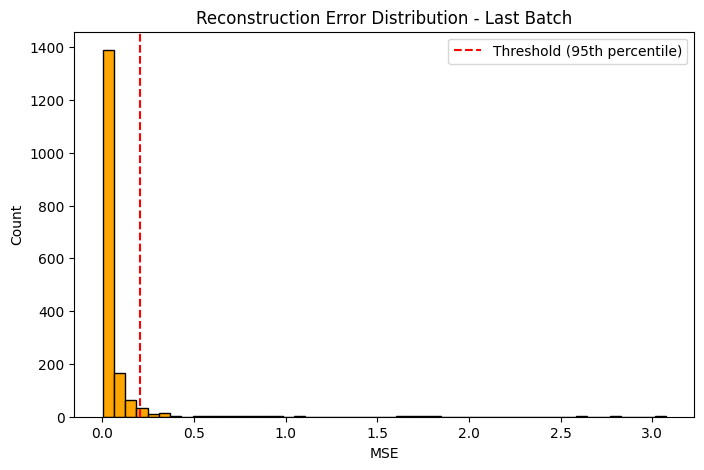

In [46]:
# 16. Visualize reconstruction error of last batch
plt.figure(figsize=(8,5))
plt.hist(batch_mse, bins=50, color='orange', edgecolor='k')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold (95th percentile)')
plt.title("Reconstruction Error Distribution - Last Batch")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.legend()
plt.show()


17. Τελική Αναφορά & Κλείσιμο

Subtask:
Εκτυπώνουμε συνοπτικά αποτελέσματα της παρακολούθησης και εμφανίζουμε ένα μήνυμα ολοκλήρωσης της διαδικασίας.

Reasoning:
Κλείνει το σενάριο με ένα καθαρό και φιλικό μήνυμα, δείχνοντας τα αποτελέσματα της ανίχνευσης και ότι η διαδικασία ολοκληρώθηκε επιτυχώς.

In [47]:
# 17. Final Summary & Closure

total_batches = n_batches
total_alerts = len(threat_log)

print("\n" + "="*60)
print("ΣΥΝΟΨΗ ΕΥΦΥΟΥΣ ΣΥΣΤΗΜΑΤΟΣ ΑΝΙΧΝΕΥΣΗΣ TOR TRAFFIC")
print("="*60)
print(f"Συνολικός αριθμός batches που επεξεργάστηκαν: {total_batches}")
print(f"Συνολικός αριθμός ανιχνευμένων υποπτων ροών: {total_alerts}")
print(f"Καλύτερο μοντέλο που χρησιμοποιήθηκε: {best_model}")
print("\nΗ διαδικασία ολοκληρώθηκε με επιτυχία. Όλα τα alerts καταγράφηκαν στο threat log.")
print("Το σύστημα είναι έτοιμο για συνεχή παρακολούθηση και ανανέωση του μοντέλου.")
print("="*60)



ΣΥΝΟΨΗ ΕΥΦΥΟΥΣ ΣΥΣΤΗΜΑΤΟΣ ΑΝΙΧΝΕΥΣΗΣ TOR TRAFFIC
Συνολικός αριθμός batches που επεξεργάστηκαν: 7
Συνολικός αριθμός ανιχνευμένων υποπτων ροών: 727
Καλύτερο μοντέλο που χρησιμοποιήθηκε: Isolation Forest

Η διαδικασία ολοκληρώθηκε με επιτυχία. Όλα τα alerts καταγράφηκαν στο threat log.
Το σύστημα είναι έτοιμο για συνεχή παρακολούθηση και ανανέωση του μοντέλου.


In [49]:
# 18. Δημιουργία DataFrame συνοπτικού πίνακα από το ensemble threat log
import pandas as pd

# Μετατροπή του threat_log_ensemble σε DataFrame
df_threats = pd.DataFrame(threat_log_ensemble)

# Προσθήκη στήλης που μετράει τον αριθμό μοντέλων που ανίχνευσαν την ίδια ροή
df_summary = df_threats.groupby(["Src_IP", "Dst_IP"]).agg(
    Total_Alerts=("Model", "count"),
    Models_Detected=("Model", lambda x: list(x.unique()))
).reset_index()

# Ταξινόμηση ανά Total_Alerts φθίνουσα
df_summary = df_summary.sort_values(by="Total_Alerts", ascending=False)

# Προβολή πρώτων 20 γραμμών
print("Συνοπτικός πίνακας υποπτων ροών (πρώτες 20):")
print(df_summary.head(20))


Συνοπτικός πίνακας υποπτων ροών (πρώτες 20):
              Src_IP           Dst_IP  Total_Alerts  \
326  131.202.240.242      224.0.0.252           213   
9      10.152.152.11    10.152.152.10           159   
416   131.202.243.49      224.0.0.252           134   
394   131.202.242.93      224.0.0.252           111   
306  131.202.240.185      224.0.0.252            83   
363   131.202.240.87      224.0.0.252            47   
342   131.202.240.70      224.0.0.252            35   
408   131.202.243.21      224.0.0.252            31   
293  131.202.240.102      224.0.0.252            30   
347   131.202.240.83      224.0.0.252            23   
137    10.152.152.11   216.58.210.226            20   
3          10.0.2.15   195.154.107.23            19   
341   131.202.240.66      224.0.0.252            18   
255    10.152.152.11   74.125.136.188            15   
260    10.152.152.11   74.125.142.127            14   
114    10.152.152.11     2.17.168.245            13   
39     10.152.152.11

/tmp/ipython-input-4159424782.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_flows.apply(lambda row: f"{row['Src_IP']} -> {row['Dst_IP']}", axis=1),


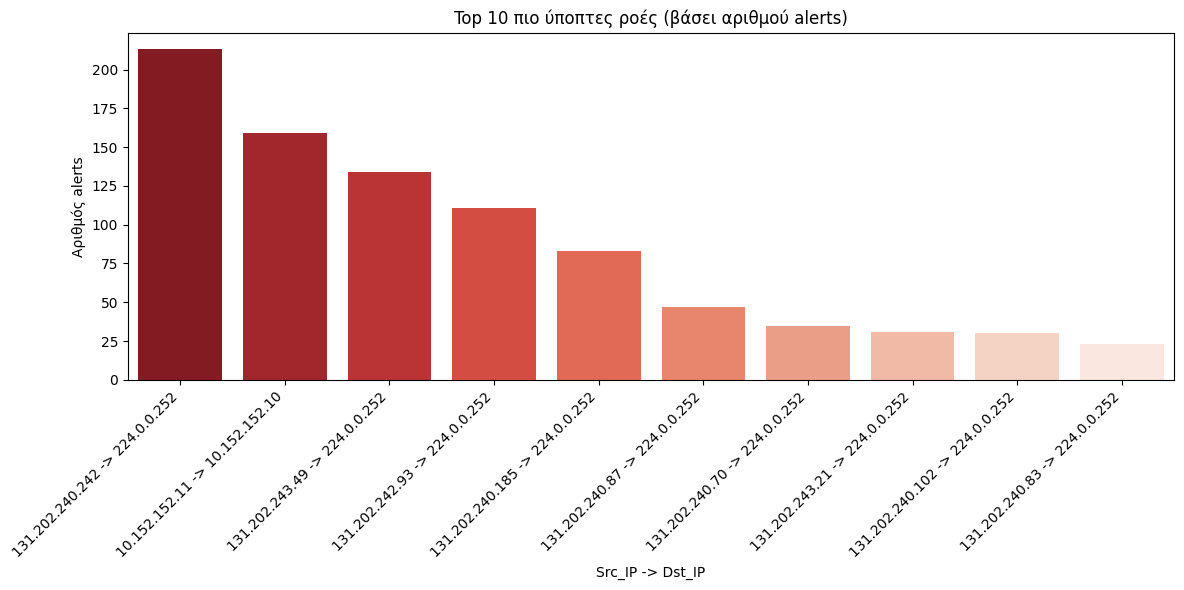

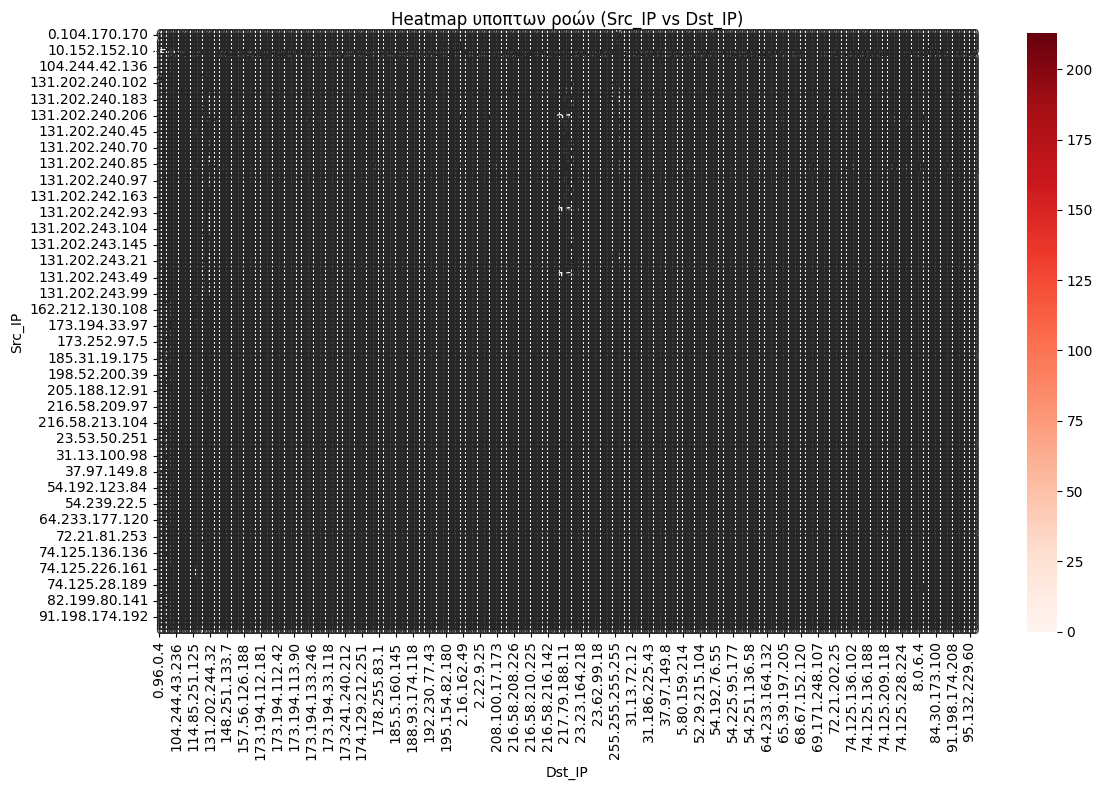

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Bar chart με τις πιο ύποπτες ροές ---
top_flows = df_summary.head(10)  # πρώτες 10 πιο ύποπτες ροές
plt.figure(figsize=(12,6))
sns.barplot(x=top_flows.apply(lambda row: f"{row['Src_IP']} -> {row['Dst_IP']}", axis=1),
            y=top_flows["Total_Alerts"], palette="Reds_r")
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 πιο ύποπτες ροές (βάσει αριθμού alerts)")
plt.ylabel("Αριθμός alerts")
plt.xlabel("Src_IP -> Dst_IP")
plt.tight_layout()
plt.show()

# --- 2. Heatmap υποπτων ροών ---
# Pivot table: Src_IP rows, Dst_IP columns, τιμή = Total_Alerts
heatmap_data = df_summary.pivot(index='Src_IP', columns='Dst_IP', values='Total_Alerts').fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Reds")
plt.title("Heatmap υποπτων ροών (Src_IP vs Dst_IP)")
plt.ylabel("Src_IP")
plt.xlabel("Dst_IP")
plt.tight_layout()
plt.show()


/tmp/ipython-input-1943615541.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(src_ips), y=list(src_counts), palette="Blues_r")


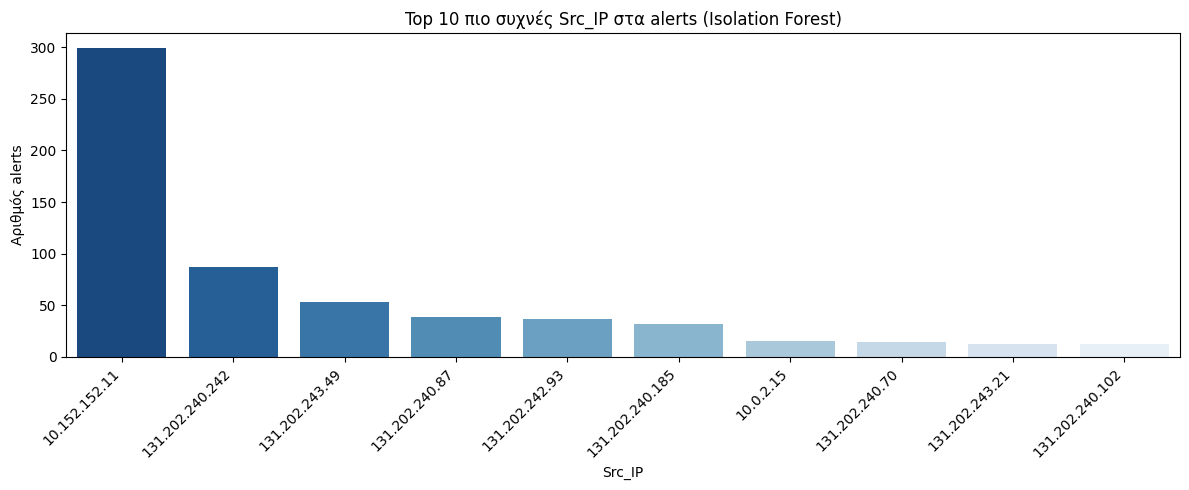

/tmp/ipython-input-1943615541.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(dst_ips), y=list(dst_counts), palette="Greens_r")


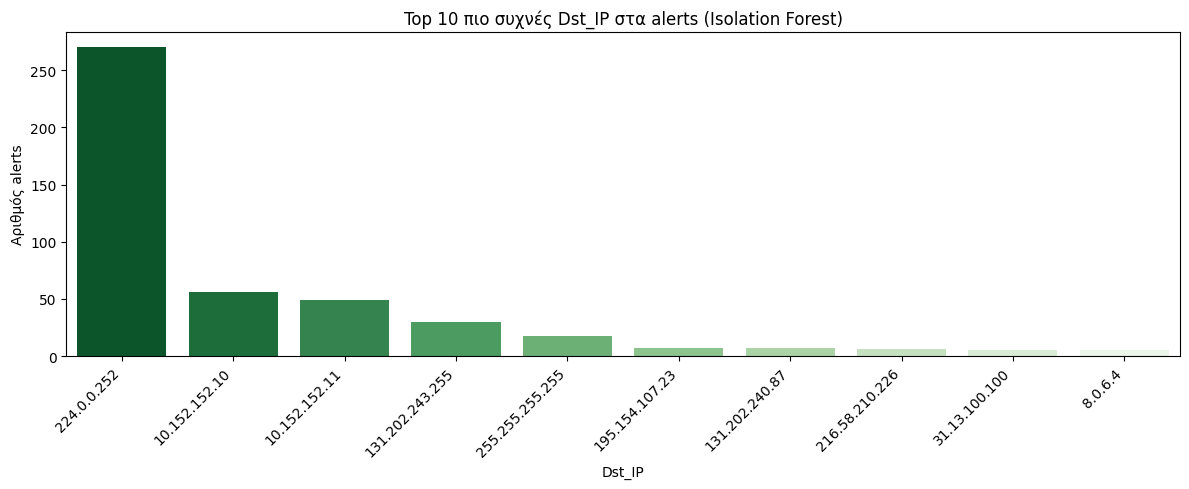

In [52]:
# 17. Οπτικοποίηση συχνότητας IP στα alerts (Best Model)
from collections import Counter

# Φιλτράρουμε τα alerts μόνο για το καλύτερο μοντέλο
df_best_model = df_threats[df_threats["Model"] == best_model]

# Υπολογισμός συχνότητας Src_IP και Dst_IP
src_counter = Counter(df_best_model["Src_IP"])
dst_counter = Counter(df_best_model["Dst_IP"])

# Top 10 πιο συχνές Src_IP
top_src = src_counter.most_common(10)
src_ips, src_counts = zip(*top_src)

plt.figure(figsize=(12,5))
sns.barplot(x=list(src_ips), y=list(src_counts), palette="Blues_r")
plt.xticks(rotation=45, ha='right')
plt.title(f"Top 10 πιο συχνές Src_IP στα alerts ({best_model})")
plt.ylabel("Αριθμός alerts")
plt.xlabel("Src_IP")
plt.tight_layout()
plt.show()

# Top 10 πιο συχνές Dst_IP
top_dst = dst_counter.most_common(10)
dst_ips, dst_counts = zip(*top_dst)

plt.figure(figsize=(12,5))
sns.barplot(x=list(dst_ips), y=list(dst_counts), palette="Greens_r")
plt.xticks(rotation=45, ha='right')
plt.title(f"Top 10 πιο συχνές Dst_IP στα alerts ({best_model})")
plt.ylabel("Αριθμός alerts")
plt.xlabel("Dst_IP")
plt.tight_layout()
plt.show()


Best Model: Isolation Forest
Συνολικός αριθμός ανιχνευμένων υποπτων ροών (Best Model): 750

Top 10 πιο ύποπτες ροές (Src_IP -> Dst_IP):
         Src_IP        Dst_IP  Total_Alerts
131.202.240.242   224.0.0.252            71
  10.152.152.11 10.152.152.10            56
 131.202.243.49   224.0.0.252            53
 131.202.242.93   224.0.0.252            36
131.202.240.185   224.0.0.252            30
 131.202.240.70   224.0.0.252            14
 131.202.240.87   224.0.0.252            14
131.202.240.102   224.0.0.252            13
 131.202.240.83   224.0.0.252            11
 131.202.243.21   224.0.0.252            11


/tmp/ipython-input-1868548369.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


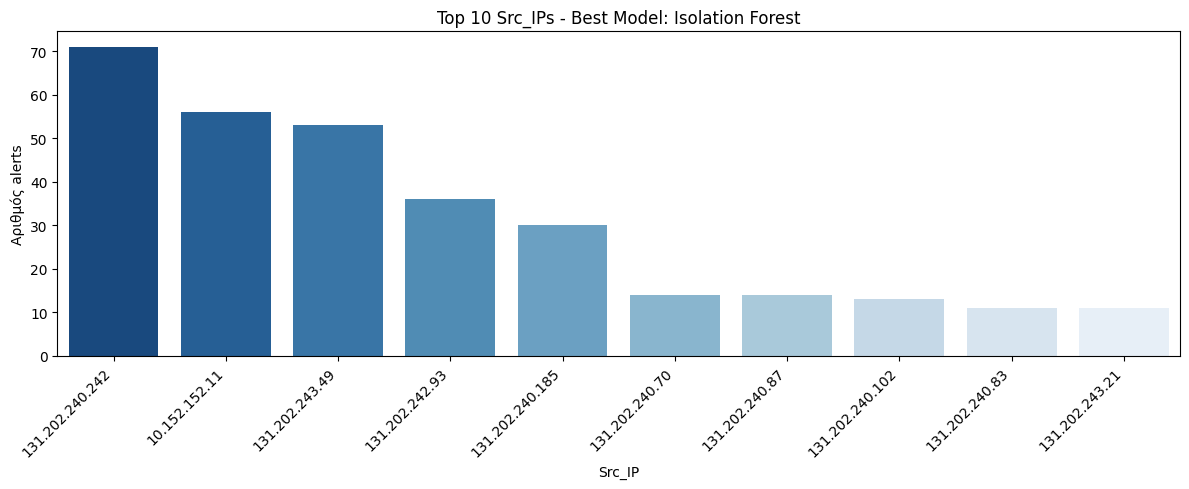

/tmp/ipython-input-1868548369.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


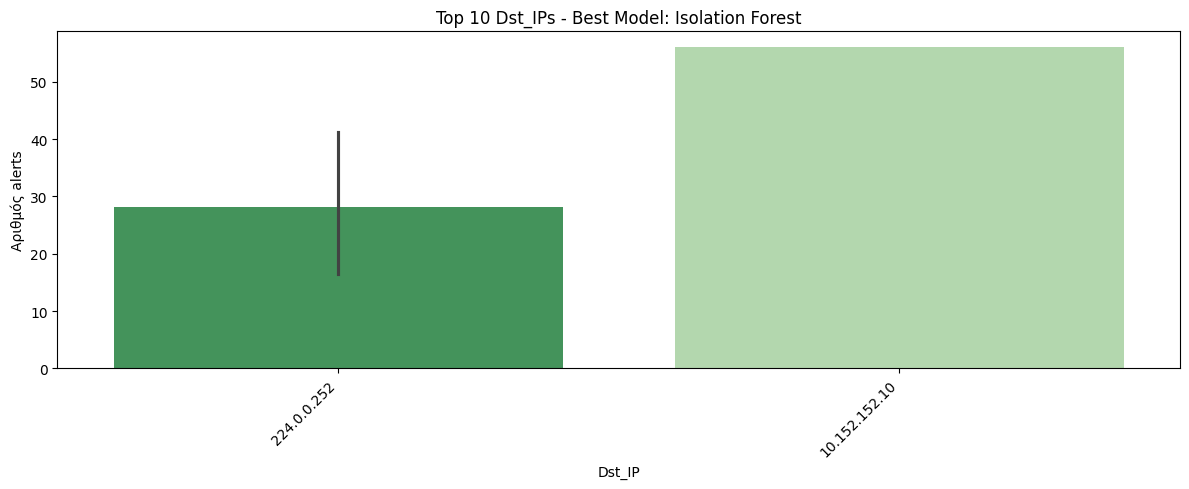


CSV files exported:
 - Threat_Log_Ensemble.csv
 - Threat_Summary.csv
 - Threat_Summary_BestModel_Isolation Forest.csv


In [53]:
# --- 18. Complete Threat Report (Best Model + Export) ---

print(f"Best Model: {best_model}")
print(f"Συνολικός αριθμός ανιχνευμένων υποπτων ροών (Best Model): {len(df_best_model)}\n")

# --- Top 10 πιο ύποπτες ροές ---
top_flows = df_best_summary.head(10)
print("Top 10 πιο ύποπτες ροές (Src_IP -> Dst_IP):")
print(top_flows.to_string(index=False))

# --- Bar chart Src_IP ---
plt.figure(figsize=(12,5))
sns.barplot(
    x=top_flows.apply(lambda row: row['Src_IP'], axis=1),
    y=top_flows["Total_Alerts"],
    palette="Blues_r"
)
plt.xticks(rotation=45, ha='right')
plt.title(f"Top 10 Src_IPs - Best Model: {best_model}")
plt.ylabel("Αριθμός alerts")
plt.xlabel("Src_IP")
plt.tight_layout()
plt.show()

# --- Bar chart Dst_IP ---
plt.figure(figsize=(12,5))
sns.barplot(
    x=top_flows.apply(lambda row: row['Dst_IP'], axis=1),
    y=top_flows["Total_Alerts"],
    palette="Greens_r"
)
plt.xticks(rotation=45, ha='right')
plt.title(f"Top 10 Dst_IPs - Best Model: {best_model}")
plt.ylabel("Αριθμός alerts")
plt.xlabel("Dst_IP")
plt.tight_layout()
plt.show()

# --- Export CSVs ---
df_threats.to_csv("Threat_Log_Ensemble.csv", index=False)
df_summary.to_csv("Threat_Summary.csv", index=False)
df_best_summary.to_csv(f"Threat_Summary_BestModel_{best_model}.csv", index=False)

print("\nCSV files exported:")
print(" - Threat_Log_Ensemble.csv")
print(" - Threat_Summary.csv")
print(f" - Threat_Summary_BestModel_{best_model}.csv")
